In [2]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import signal, optimize
from scipy.stats import zscore
from pathlib import Path
from itertools import product
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="fooof")
from fooof import FOOOF


In [3]:
# functions 
def get_path_from_dir(base_folder, file_name):
    """
    Search for a file within the specified directory and its subdirectories
    by matching the given file name.

    Args:
    - base_folder (str): The directory path to start the search from.
    - file_name (str): The specific file name or part of the file name to be matched.

    Returns:
    - str or None: The path to the first file found with the given name,
      or None if no file is found.
    """
    base_folder = Path(base_folder)
    
    # Iterate through all files and directories in the base_folder
    for file in base_folder.glob('**/*'):
        if file.is_file() and file_name in file.name:
            return file.resolve()  # Return the path of the first file found with the given name
    
    # Print an error message if no file with the given name is found
    print(f"No '{file_name}' file found in the directory.")
    return None



def compute_fooof_psd(data_path, fs):

    all_data = np.load(data_path)

    n_channels, n_times = all_data.shape

    n_fft = 2*fs
    all_psd = []

    # Initialize FOOOF model
    fm = FOOOF(verbose=False)

    freq_range = [1, 50]

    for ch in tqdm(range(n_channels)):

        frequencies, psd = signal.welch(all_data[ch, :], fs, nperseg=n_fft)

        fm.fit(frequencies, psd, freq_range)

        fooof_spec = fm.fooofed_spectrum_ - fm._ap_fit

        all_psd.append(fooof_spec)

    all_psd = np.array(all_psd)
    z_psd = zscore(all_psd, axis=1, nan_policy = 'omit')

    mean_psd = np.nanmean(z_psd, axis=0)
    z_psd = np.nan_to_num(z_psd, nan=0)
    fq = fm.freqs

    return fq, z_psd


def plot_probe_psds(fq, z_psd, clim, brain_area):

    n_channels = z_psd.shape[0]

    # create some things needed for specifying the x-axis
    x, y = np.meshgrid(fq, np.arange(n_channels))

    fig = plt.figure(figsize=(2, 6), dpi=100)
    plt.pcolor(x, y, z_psd, vmin =clim[0], vmax = clim[1], cmap='magma')
    # Add a colorbar
    colorbar = plt.colorbar(orientation='vertical', aspect=50)
    # Add a label to the colorbar
    colorbar.set_label('Power(z)', rotation=90, labelpad=10)
    plt.xlabel('Frequency')
    plt.xticks((1, 10, 20, 30, 40, 50))
    plt.ylabel('Channel Number')
    plt.title('PSD in ' + brain_area)

    return None

def coherogram(lfp1, lfp2, n_perseg, n_fft, n_overlap, fq_min, fq_max, fs):
    """Computes a coherogram for an LFP stream of arbitrary length using a Hamming window.

    Inputs: 
        lfp1 (ndarray):  Datastream for one LFP channel
        lfp2 (ndarray):  Datastream for a different LFP channel
        n_perseg(int):   Window over which each piece of the coherogram is evaluated
        n_fft (int):     Number of samples to compute the FFT over (typically n_perseg)
        fq_min (int):    Minimum frequency coherence is computed at
        fq_max (int):    Maximum frequency coherence is evaluated at
        fs (int):        Sampling frequency (in Hz) of the LFP data (typically 1000 Hz)
            
    Returns:
        ts (ndarray):    Timestamps of each element of the coherogram
        coh (ndarray):   A n_frequencies x n_times array where each element describes the coherence between
                         lfp1 and lfp2 at each timestep and frequency
        z_coh (ndarray): Z-scored coherence (zscore applied to each frequency)
        freqs (ndarray): Array detailing which frquencies define the rows of coh     
    """
    
    if n_overlap < 1:
        n_overlap = int(n_overlap * n_perseg) # convert to number of segments if a fraction provided (noverlap <= 1)

    # find out the times to compute coherence at   
    ts = np.arange(0, lfp1.shape[0] + (n_perseg - n_overlap), n_perseg - n_overlap)

    n_freqs = ((fq_max - fq_min) * n_perseg // 1000) + 1

    # define the starts and stops of each window to assess coherence over
    # first columns is starts, second is stops
    win_details = np.zeros(shape=(len(ts), 2))

    # loop over each timestep and find appropriate windows. Truncate windows at the 
    # very beginning and end of of the data stream
    for i_t in range(len(ts)):

        # make centered windows
        win_details[i_t, 0] = ts[i_t] - np.floor((n_perseg/2)) # window starts
        win_details[i_t, 1] = ts[i_t] + np.floor((n_perseg/2)) # window ends

        # is the left border of the window before the start of the session?
        if win_details[i_t, 0] < 0: 
            # then set the window start to zero
            win_details[i_t, 0] = 0

        # is the right border of the window longer than the end of the session?
        if win_details[i_t, 1] > lfp1.shape[0]:
            # then set the window end to the end of the session
            win_details[i_t, 1] = lfp1.shape[0]

    # be sure these are ints
    win_details = win_details.astype(int)
    
    # run the coherence on the first window to see how many frequencies are obtained
    freqs, test_coh = signal.coherence(lfp1[0:n_perseg], lfp1[0:n_perseg], 1000, nfft=1000)
    
    n_freqs = len(freqs)

    # intialize an array to accumulate the coherence data into
    coh = np.zeros(shape=(n_freqs, len(ts)))
    coh[:] = np.nan

    # loop over each timestep
    for t in range(len(ts)):
        _, coh[:, t] = signal.coherence(lfp1[win_details[t, 0]: win_details[t, 1]],
                                           lfp2[win_details[t, 0]: win_details[t, 1]],
                                           fs=fs, nfft = n_fft, window='hamming')

    # select the frequency range defined by fq_min and fq_max
    freqs2keep = (freqs >= fq_min) & (freqs <= fq_max)

    # zscore the coherence
    z_coh = np.zeros_like(coh)
    for f in range(len(freqs)):
        f_mean = np.nanmean(coh[f,:])
        f_std = np.nanstd(coh[f,:])
        z_coh[f,:] = (coh[f,:] - f_mean) / f_std



    return ts, coh[freqs2keep,: ], z_coh[freqs2keep, :], freqs[freqs2keep]


In [27]:
# get paths to LFP data from each probe
base_folder = 'D:/D20231221_Rec06_g0/'

cdn_path = get_path_from_dir('D:/D20231221_Rec06_g0/D20231221_Rec06_g0_imec0', 'sync_lfp')
cdn_ts_path = get_path_from_dir('D:/D20231221_Rec06_g0/D20231221_Rec06_g0_imec0', 'sync_lfp_ts')
ofc_path = get_path_from_dir('D:/D20231221_Rec06_g0/D20231221_Rec06_g0_imec1', 'sync_lfp')
ofc_ts_path = get_path_from_dir('D:/D20231221_Rec06_g0/D20231221_Rec06_g0_imec1', 'sync_lfp_ts')

# sampling frequency
fs = 1000

In [5]:
# compute PSDs for each channel on each probe
fq, ofc_psd = compute_fooof_psd(ofc_path, fs)
fq, cdn_psd = compute_fooof_psd(cdn_path, fs)

100%|██████████| 385/385 [01:39<00:00,  3.87it/s]


In [ ]:
# plot the z-scored PSDs for each channel on each probe
plot_probe_psds(fq, ofc_psd, [0,3], 'OFC')
plot_probe_psds(fq, cdn_psd, [0,3], 'CdN')

In [6]:
# find channels with significant theta power

# get mean of theta band
ofc_theta_power = np.mean(ofc_psd[:, 1:2], axis=1)
cdn_theta_power = np.mean(ofc_psd[:, 1:2], axis=1)

# find channels with significant power
sig_ofc_theta_ch = ofc_theta_power > 2
sig_cdn_theta_ch = cdn_theta_power > 2

# create an array of channel numbers
ch_nums = np.arange(ofc_theta_power.shape[0])

# find the ID of the channels with significant theta power
ofc_ch = ch_nums[sig_ofc_theta_ch]
cdn_ch = ch_nums[sig_cdn_theta_ch]

# get the unique combinations of channel pairs with significant theta in both brain areas
ch_pairs = np.array(list(product(ofc_ch, cdn_ch)))

print(str(len(ch_pairs)) + ' candidate channel pairs')

21904 candidate channel pairs


In [7]:
# load data associated with each probe
cdn_data = np.load(cdn_path)
cdn_ts = np.load(cdn_ts_path)
ofc_data = np.load(ofc_path)
ofc_ts = np.load(ofc_ts_path)

coh_data = []

max_time = (fs * 60)*10 # only look at first 10 minutes of the recording

# now loop over the combinations from both directions simultaneously
for c_ix in tqdm(range(ch_pairs.shape[0])):

    c_ix = c_ix

    coh_fq, coh = signal.coherence(cdn_data[ch_pairs[c_ix, 0], 0:max_time],
                                   ofc_data[ch_pairs[c_ix, 1], 0:max_time], fs=fs)
    
    # filter the data so we only store our range of interest
    coh_data.append(coh[coh_fq < 50])

# convert lists to arrays
coh_data = np.array(coh_data)
coh_fq = coh_fq[coh_fq < 50]

100%|██████████| 21904/21904 [39:52<00:00,  9.15it/s]


In [10]:
z_coh = zscore(coh_data, axis=1)
sig_theta_ix = (z_coh[:,1] > 2) & (coh_data[:,1] > .15) # screen in both relative and absolute terms
print('n sig theta channel pairs = ' + str(np.sum(sig_theta_ix)))
sig_theta_ch_nums = ch_pairs[sig_theta_ix,:]
sig_theta_coh = coh_data[sig_theta_ix,1]

n sig theta channel pairs = 14


In [11]:
# identify and remove noisy chanel pairs for theta
probe0_channels = np.unique(sig_theta_ch_nums[:, 0])
probe1_channels = np.unique(sig_theta_ch_nums[:, 1])

p0_channels_to_remove = []
p1_channels_to_remove = []

for ix, p0_ch in enumerate(probe0_channels):

    p0_pairs = sig_theta_ch_nums[sig_theta_ch_nums[:, 1 ] == p0_ch,:]
    
    # if this channel is coherence with over 100 other ones, then it's likely noise
    if p0_pairs.shape[0] > 100:

        p0_channels_to_remove.append(p0_ch)

# convert to an array 
p0_channels_to_remove = np.array(p0_channels_to_remove) 
p0_rows2remove = np.isin(sig_theta_ch_nums[:, 0], p0_channels_to_remove)

for ix, p1_ch in enumerate(probe1_channels):

    p1_pairs = sig_theta_ch_nums[sig_theta_ch_nums[:, 1 ] == p1_ch,:]
    
    # if this channel is coherence with over 100 other ones, then it's likely noise
    if p1_pairs.shape[0] > 100:

        p1_channels_to_remove.append(p1_ch)

# convert to an array 
p1_channels_to_remove = np.array(p1_channels_to_remove) 
p1_rows2remove = np.isin(sig_theta_ch_nums[:, 1], p1_channels_to_remove)



sig_theta_ch_nums = sig_theta_ch_nums[(~p0_rows2remove) & (~p1_rows2remove),:]

print('num significant channel pairs: ' + str(sig_theta_ch_nums.shape[0]))


num significant channel pairs: 14


Text(0.5, 1.0, 'Localized Theta Coherence')

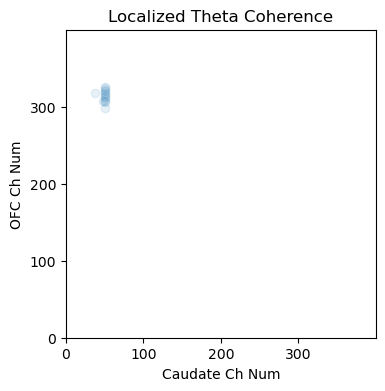

In [12]:
fig = plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(sig_theta_ch_nums[:, 0], sig_theta_ch_nums[:, 1], alpha=.1, c='tab:blue')

plt.xlabel('Caudate Ch Num')
plt.ylabel('OFC Ch Num')
plt.xlim([0, 400])
plt.xticks((0, 100, 200, 300))
plt.yticks((0, 100, 200, 300))
plt.ylim([0, 400])
plt.title('Localized Theta Coherence')

In [13]:
# find the unique channels where the significant coherence occured
sig_cdn_ch = np.unique(sig_theta_ch_nums[:, 0])
sig_ofc_ch = np.unique(sig_theta_ch_nums[:, 1])

# average over those channels
cdn_lfp = np.mean(cdn_data[sig_cdn_ch, :], axis=0)
ofc_lfp = np.mean(ofc_data[sig_ofc_ch, :], axis=0)

In [14]:
# filter out electrical noise at 60Hz and its harmonics
# (note this can be done on the entire LFP matrix at once if you filter along the time axis
# I just do it channel-by-channel here)
for f0 in [60,120,180]:
    # design 10th order band-stop (Butterworth) filter for each noise frequency +/- 2 Hz
    notchfilt = signal.butter(10, (f0-2,f0+2), 'bandstop', fs=1000, output='sos')
    
    # apply notch filter to LFP, using a forward and reverse pass to cancel out phase lags at each frequency
    cdn_lfp = signal.sosfiltfilt(notchfilt, cdn_lfp)
    ofc_lfp = signal.sosfiltfilt(notchfilt, ofc_lfp)

In [15]:
# load the event_codes + event_times for this directory
task_events = np.load(base_folder + '/sync_event_codes.npy')

# find the start and stop of each trial
trial_starts = np.argwhere(task_events[:,0] == 9).flatten()
trial_ends = np.argwhere(task_events[:,0] == 18).flatten() + 1
last_end_time = round(task_events[-1, 1])

# load the behavior
bhv = pd.read_csv(get_path_from_dir(base_folder, '_bhv'))

bhv = bhv.iloc[0:len(trial_ends)]

align_event = 40

In [132]:
# let's try another way of computing the trial-wise coherence
t_offset = 3000
cdn_trial_lfp = np.zeros(shape=(len(trial_ends), t_offset*2))
ofc_trial_lfp = np.zeros(shape=(len(trial_ends), t_offset*2))
lfp_ts = np.arange(2*t_offset)

cdn_trial_lfp[:] = np.nan
ofc_trial_lfp[:] = np.nan

# loop over the trials
print('Accumulating single-trial LFPs')
for t in tqdm(range(len(trial_ends)-1)):

    # get the events and times of this trial
    trial_events = task_events[trial_starts[t] : trial_ends[t], :]

    # make a spike table if a choice was presented (40 is the event code for pics on)
    if np.any(trial_events[:, 0] == align_event):

        pics_on_time = int(trial_events[np.argwhere(trial_events[:,0] == align_event).flatten(), 1])
        cdn_pics_on_ix = np.argmin(np.abs(cdn_ts - pics_on_time))
        ofc_pics_on_ix = np.argmin(np.abs(ofc_ts - pics_on_time))

        cdn_trial_lfp[t,:] = cdn_lfp[cdn_pics_on_ix-t_offset : cdn_pics_on_ix+t_offset]
        ofc_trial_lfp[t,:]  = ofc_lfp[ofc_pics_on_ix-t_offset : ofc_pics_on_ix+t_offset]

ts, test_coh, _, freqs = coherogram(ofc_trial_lfp[0,:], cdn_trial_lfp[0,:], 1000, 1000, .95, 1, 100, 1000)

# initialize arrays for the trialwise coherence
coh_trials = np.zeros(shape=(len(freqs), len(ts), len(trial_ends)))
coh_trials[:] = np.nan
z_coh_trials = np.zeros(shape=(len(freqs), len(ts), len(trial_ends)))
z_coh_trials[:] = np.nan

print('\nComputing trial-by-trial coherence')
for t in tqdm(range(len(trial_ends))):

    if not np.isnan(np.sum(ofc_trial_lfp[t,:])):
        ts, coh_trials[:,:,t], z_coh_trials[:,:,t], freqs = coherogram(ofc_trial_lfp[t,:], cdn_trial_lfp[t,:],
                                                                        1000, 1000, .95, 1, 100, 1000)

ts = ts - t_offset
t_start = np.argmin(np.abs(ts - -2000))
t_end = np.argmin(np.abs(ts - 2000))

lfp_ts_start = np.argmin(np.abs(lfp_ts - -2000))
lfp_ts_end = np.argmin(np.abs(lfp_ts - 2000))


# chop off the borders because that will blow the zscore
coh_trials = coh_trials[:,t_start:t_end,:]   
z_coh_trials = z_coh_trials[:,t_start:t_end,:]    
ts = ts[t_start:t_end]      

Accumulating single-trial LFPs


100%|██████████| 1245/1245 [01:02<00:00, 19.81it/s]



Computing trial-by-trial coherence


100%|██████████| 1246/1246 [02:48<00:00,  7.40it/s]


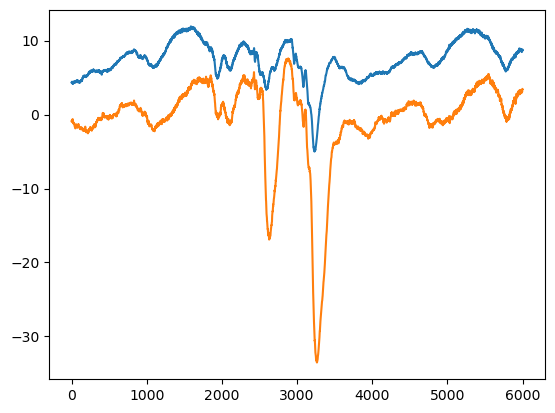

In [133]:
plt.plot(lfp_ts, np.nanmean(cdn_trial_lfp, axis=0))
plt.plot(lfp_ts, np.nanmean(ofc_trial_lfp, axis=0))


In [40]:
# create some indices
s12_ix = bhv['state'] < 3
s3_ix = bhv['state'] == 3
sacc1 = bhv['n_sacc'] == 1
sacc2 = bhv['n_sacc'] == 2

(20.0, 60.0)

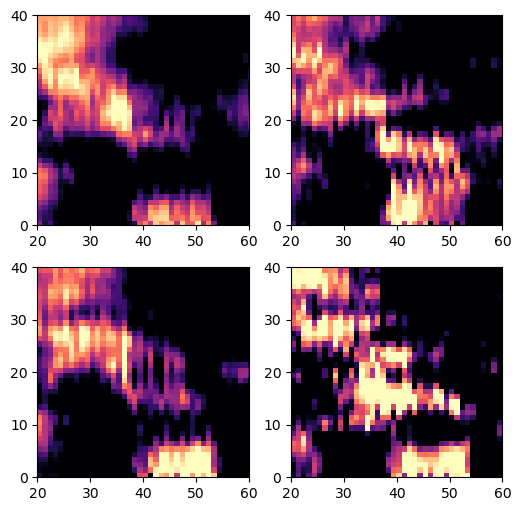

In [44]:
single_sacc_s2_coh = np.nanmean(coh_trials[:,:, s12_ix & sacc1], axis=2)
double_sacc_s2_coh = np.nanmean(coh_trials[:,:, s12_ix & sacc2], axis=2)

single_sacc_s3_coh = np.nanmean(coh_trials[:,:, s3_ix & sacc1], axis=2)
double_sacc_s3_coh = np.nanmean(coh_trials[:,:, s3_ix & sacc2], axis=2)

f_mean = np.mean(np.concatenate((single_sacc_s2_coh, double_sacc_s2_coh, 
                                 single_sacc_s3_coh, double_sacc_s3_coh), axis=1), axis=1)

f_mean = f_mean.reshape(len(f_mean), 1)

f_std = np.std(np.concatenate((single_sacc_s2_coh, double_sacc_s2_coh, 
                                single_sacc_s3_coh, double_sacc_s3_coh), axis=1), axis=1)

f_std = f_std.reshape(len(f_mean), 1)

z_single_state2 = (single_sacc_s2_coh - f_mean) / f_std
z_double_state2 = (double_sacc_s2_coh - f_mean) / f_std

z_single_state3 = (single_sacc_s3_coh - f_mean) / f_std
z_double_state3 = (double_sacc_s3_coh - f_mean) / f_std

cmin = 0
cmax = 2
ymin = 0
ymax = 40
xmin = np.argmin(np.abs(ts - -1000))
xmax = np.argmin(np.abs(ts - 1000))

fig, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=100)

ax[0,0].pcolor(z_single_state2, vmin = cmin, vmax=cmax, cmap='magma')
ax[0,0].set_ylim(ymin, ymax)
ax[0,0].set_xlim(xmin, xmax)

ax[0,1].pcolor(z_double_state2, vmin = cmin, vmax=cmax, cmap='magma')
ax[0,1].set_ylim(ymin, ymax)
ax[0,1].set_xlim(xmin, xmax)


ax[1,0].pcolor(z_single_state3, vmin = cmin, vmax=cmax, cmap='magma')
ax[1,0].set_ylim(ymin, ymax)
ax[1,0].set_xlim(xmin, xmax)


ax[1,1].pcolor(z_double_state3, vmin = cmin, vmax=cmax, cmap='magma')
ax[1,1].set_ylim(ymin, ymax)
ax[1,1].set_xlim(xmin, xmax)


(19.0, 59.0)

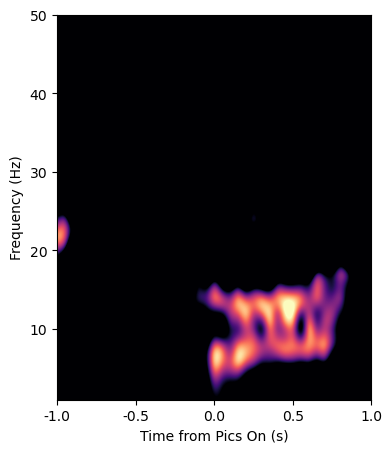

In [135]:
xticks = np.array([-1000, -500, 0, 500, 1000])
xtick_ix = [np.argmin(np.abs(ts - xtick)) - 1 for xtick in xticks]

diff_z = z_double_state2 - z_single_state2

plt.figure(figsize=(5,5))
plt.imshow(diff_z, cmap='magma', interpolation='bicubic', vmin = 1, vmax = 2)


# Customize plot
#plt.colorbar(label='Coherence')
plt.xlabel('Time from Pics On (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(1,50)
plt.xticks(xtick_ix, xticks/1000)
plt.xlim(xtick_ix[0],xtick_ix[-1])

#plt.savefig('Single_double_coh.svg', format='svg')

C:\Users\Thomas Elston\AppData\Local\Temp\ipykernel_13488\1781261102.py:6: RuntimeWarning: Mean of empty slice
  choice_coh = np.nanmean(coh_trials[:, pics_on:pics_off,:], axis=1).T


Text(0.5, 1.0, 'State C')

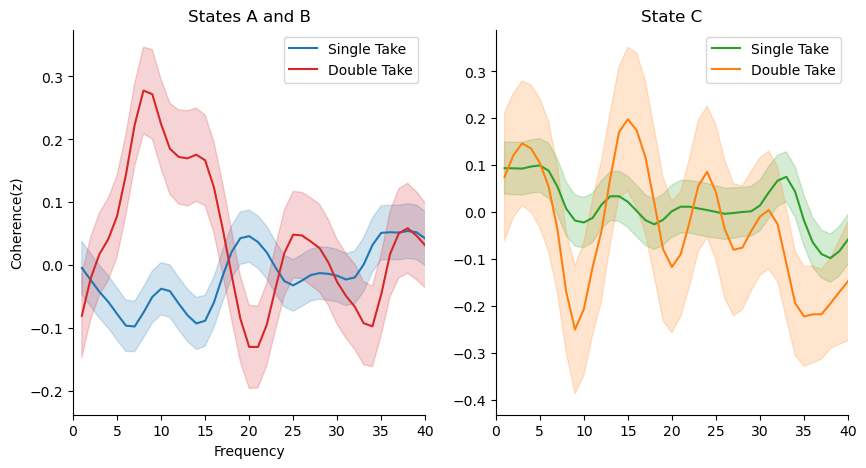

In [136]:
# compare coherences across the choice period
pics_on = np.argmin(np.abs(ts - 0))
pics_off = np.argmin(np.abs(ts - 500))


choice_coh = np.nanmean(coh_trials[:, pics_on:pics_off,:], axis=1).T
z_choice_coh = zscore(choice_coh, axis=0, nan_policy='omit')
choice_coh = z_choice_coh

s12_sacc1_mean = np.nanmean(choice_coh[sacc1 & s12_ix, :], axis=0)
s12_sacc1_sem = np.nanstd(choice_coh[sacc1 & s12_ix, :], axis=0) / np.sqrt(np.sum(s12_ix & sacc1))

s12_sacc2_mean = np.nanmean(choice_coh[sacc2 & s12_ix, :], axis=0)
s12_sacc2_sem = np.nanstd(choice_coh[sacc2 & s12_ix, :], axis=0) / np.sqrt(np.sum(s12_ix & sacc2))

s3_sacc1_mean = np.nanmean(choice_coh[sacc1 & s3_ix, :], axis=0)
s3_sacc1_sem = np.nanstd(choice_coh[sacc1 & s3_ix, :], axis=0) / np.sqrt(np.sum(s3_ix & sacc1))

s3_sacc2_mean = np.nanmean(choice_coh[sacc2 & s3_ix, :], axis=0)
s3_sacc2_sem = np.nanstd(choice_coh[sacc2 & s3_ix, :], axis=0) / np.sqrt(np.sum(s3_ix & sacc2))


fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)


ax[0].plot(freqs, s12_sacc1_mean, color='tab:blue', label = 'Single Take')
ax[0].fill_between(freqs, s12_sacc1_mean - s12_sacc1_sem, s12_sacc1_mean + s12_sacc1_sem,
                 alpha=.2, color='tab:blue')

ax[0].plot(freqs, s12_sacc2_mean, color='tab:red', label = 'Double Take')
ax[0].fill_between(freqs, s12_sacc2_mean - s12_sacc2_sem, s12_sacc2_mean + s12_sacc2_sem,
                 alpha=.2, color='tab:red')

ax[0].legend()
ax[0].set_xlim(0, 40)
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Coherence(z)')
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set_title('States A and B')

ax[1].plot(freqs, s3_sacc1_mean, color='tab:green', label = 'Single Take')
ax[1].fill_between(freqs, s3_sacc1_mean - s3_sacc1_sem, s3_sacc1_mean + s3_sacc1_sem,
                 alpha=.2, color='tab:green')

ax[1].plot(freqs, s3_sacc2_mean, color='tab:orange', label = 'Double Take')
ax[1].fill_between(freqs, s3_sacc2_mean - s3_sacc2_sem, s3_sacc2_mean + s3_sacc2_sem,
                 alpha=.2, color='tab:orange')
ax[1].set_xlim(0, 40)
ax[1].legend()
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_title('State C')



